#####  Notebook editor: Anastasios-Polykarpos Athanasiadis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mstats
from numba import jit, njit, vectorize

In [2]:
%%javascript
/* for automatic equations numbering */
/* source: https://github.com/ipython-contrib/jupyter_contrib_nbextensions/tree/master/src/jupyter_contrib_nbextensions/nbextensions/equation-numbering */
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});
MathJax.Hub.Queue(
  ["resetEquationNumbers", MathJax.InputJax.TeX],
  ["PreProcess", MathJax.Hub],
  ["Reprocess", MathJax.Hub]
);

<IPython.core.display.Javascript object>

### Milshtein algoritm, page 199pdf

##### *Milstein algorithm $\equiv$ Euler-Maruyama algorithm*, for $g(x(t)) = const$

\begin{equation}\label{SDE}
    \dot{x} = q(x(t)) + g(x(t))\xi(t) 
\end{equation}

In [3]:
@njit()
def q(x, t):
    '''ax - x^3'''
    return a*x - x**3
@njit()
def g(x, t):
    '''\sqrt{D}'''
    return np.sqrt(D)

In [4]:
# Parameter values (taken by figure 7.4 page 222) 
a = 1
D = 1
# Initial conditions 
x_0 = 0
t_0 = 0
# dg/dx
g_prime = 0

\begin{equation}\label{SDE_}
    \eqref{SDE}\Rightarrow\dot{x} = x(t) - x(t)^3 + 1\xi(t)
\end{equation}

#### 1. Simulate single trajectory

In [5]:
h = 0.01   # time step of numerical calculation
h_sqrt = np.sqrt(h)
n_write = 200
n_step = 10

In [6]:
@njit()
def Euler_Maruyama(n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                   x_0 = x_0, t_0 = t_0, U = np.random.normal(loc = 0.0, scale = 1.0, size = int(n_write*n_step)).reshape(n_step, n_write)):
    '''
    SDE:    dx/dt   = q(a, x(t)) + g(x(t))ξ(t)
    input:  h       = time step of numerical calculation
            n_step  = #numerical calculations before storing x value
            n_write = #records of x value
            U       = Random Variable of Noise, size (n_step*n_write) 
    output: trajectory of the SDE solution, for standard gaussian noise
    return: T(n_write), X(n_write)
    '''
    X = np.zeros(n_write)
    T = np.zeros_like(X)
#     U = np.reshape(U, (n_step, n_write, -1))
    x = x_0
    t = t_0
    for i_write in range(n_write):
        for i_step in range(n_step):
#             print(U[i_step, i_write].shape)
            uh = h_sqrt * U[i_step, i_write]  #np.random.normal(loc = 0.0, scale = 1.0) #ui, indepednent Gaussian RV
            x = x + h * q(x, t) + g(x, t) * uh + 0.5 * g(x, t) * g_prime * h * uh**2 #+ bigger order corrections 
            t = t + h
        # store every h*n_step = 0.1 time units
#         print(x.shape)
        X[i_write] = x 
        T[i_write] = t 
    return T, X

In [7]:
%time _ = Euler_Maruyama()

CPU times: user 1.5 s, sys: 13.4 ms, total: 1.52 s
Wall time: 1.54 s


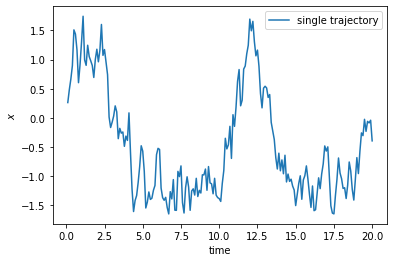

In [8]:
T, X = Euler_Maruyama()
plt.plot(T, X, label = 'single trajectory')
plt.xlabel('time')
plt.ylabel(r'$x$')
plt.legend()
plt.show()

#### 2. Simulate `n_sim` trajectories

In [9]:
# number of simulated trajectories
n_sim = 1e4
n_sim = int(n_sim)
# initial conditions of each trajectory
x_0 = np.zeros(n_sim)

In [10]:
# @njit()
def Trajectories_Euler_Maruyama(n_sim = n_sim, func = Euler_Maruyama,
                                n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                                x_0 = np.zeros(n_sim), t_0 = t_0, 
                                U = np.random.normal(loc = 0.0, scale = 1.0, size = n_write*n_step*n_sim).reshape(n_step, n_write, n_sim)):
    X = np.zeros([n_write, n_sim])
    U_ = U#.reshape(n_step, n_write, n_sim)
    for j in range(n_sim):
        x0 = x_0[j]
        U = U_[:, :, j]
        X[:, j] = func(n_write = n_write, n_step = n_step, h = h, h_sqrt = h_sqrt,
                       x_0 = x0, t_0 = t_0, U = U)[1]
    return Euler_Maruyama()[0], X

In [11]:
T, X = Trajectories_Euler_Maruyama(x_0 = np.zeros(n_sim))

In [28]:
%time _ = Trajectories_Euler_Maruyama()

CPU times: user 354 ms, sys: 4.28 ms, total: 359 ms
Wall time: 358 ms


In [13]:
X_bar = np.mean(X, axis = 1) # average across the simulated trajectories

X_var = np.var(X, axis = 1) # variance across simulated trajectories

quantiles = mstats.mquantiles(X, axis=1)

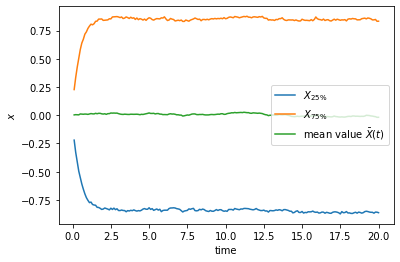

In [14]:
X_25, X_75 = quantiles[:,0], quantiles[:,2]
plt.plot(T, X_25, label=r'$X_{25\%}$')
plt.plot(T, X_75, label=r'$X_{75\%}$')
plt.plot(T, X_bar, label = r'mean value $\bar{X}(t)$');
# plt.fill_between(T, X_bar + X_var, X_bar - X_var, alpha = 0.3) # X_var ~ 0 
plt.xlabel('time')
plt.ylabel(r'$x$')
plt.legend(loc = 'center right')
plt.show()

Since the trajectory can stabilize to either $+\sqrt{a}$ or $-\sqrt{a}$, we next plot the mean of $X>0$ (and use $std(X|X>0)$ for error estimation) and $\mathbb{E}(X| X<0) \pm std(X|X<0)$. 

In [15]:
Xpos = X[:, X.mean(axis = 0)>0]
Xneg = X[:, X.mean(axis = 0)<0]
# mean across simulated trajectories
Xpos_bar = Xpos.mean(axis = 1)
Xneg_bar = Xneg.mean(axis = 1)
# std across simulated trajectories
Xpos_std = np.std(Xpos, axis = 1) 
Xneg_std = np.std(Xneg, axis = 1) 

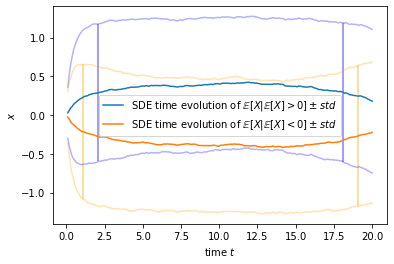

In [16]:
plt.plot(T, Xpos_bar, label = r'SDE time evolution of $\mathbb{E}[X|\mathbb{E}[X]>0]\pm std$');
plt.plot(T, Xneg_bar, label = r'SDE time evolution of $\mathbb{E}[X|\mathbb{E}[X]<0]\pm std$');
plt.plot(T, Xpos_bar + Xpos_std, alpha = 0.3, color = 'b') 
plt.plot(T, Xpos_bar - Xpos_std, alpha = 0.3, color = 'b') 
plt.plot(T, Xneg_bar - Xneg_std, alpha = 0.3, color = 'orange')
plt.plot(T, Xneg_bar + Xneg_std, alpha = 0.3, color = 'orange')
plt.vlines(T[10], Xneg_bar[10], Xneg_bar[10] + Xneg_std[10], alpha = 0.5, color = 'orange')
plt.vlines(T[10], Xneg_bar[10], Xneg_bar[10] - Xneg_std[10], alpha = 0.5,color = 'orange')
plt.vlines(T[-10], Xneg_bar[-10], Xneg_bar[-10] + Xneg_std[-10],alpha = 0.5, color = 'orange')
plt.vlines(T[-10], Xneg_bar[-10], Xneg_bar[-10] - Xneg_std[-10], alpha = 0.5,color = 'orange')
plt.vlines(T[20], Xpos_bar[20], Xpos_bar[20] + Xpos_std[20],alpha = 0.5, color = 'b')
plt.vlines(T[20], Xpos_bar[20], Xpos_bar[20] - Xpos_std[20],alpha = 0.5, color = 'b')
plt.vlines(T[-20], Xpos_bar[-20], Xpos_bar[-20] + Xpos_std[-20],alpha = 0.5, color = 'b')
plt.vlines(T[-20], Xpos_bar[-20], Xpos_bar[-20] - Xpos_std[-20],alpha = 0.5, color = 'b')
plt.xlabel(r'time $t$')
plt.ylabel(r'$x$')
plt.legend()
plt.show()

**Note:** The issue is that the trajectories jumps from $1$ to $-1$ and vice versa, so they aren't clearly positive or negative. That's why next I plot the mean of $|X|$.

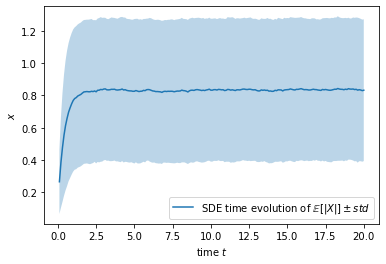

In [17]:
plt.plot(T, np.abs(X).mean(axis = 1), label = r'SDE time evolution of $\mathbb{E}[|X|]\pm std$');
plt.fill_between(T, np.abs(X).mean(axis = 1) + np.std(np.abs(X), axis = 1), np.abs(X).mean(axis = 1) - np.std(np.abs(X), axis = 1), alpha = 0.3) 
plt.legend(loc = 'lower right')
plt.xlabel(r'time $t$')
plt.ylabel(r'$x$')
plt.show()

#### 3. Construct a histogram with the values taken for the system over a long trajectory at the stationary state

After t=10, from the figure above it's concluded that the system is at the stationary state


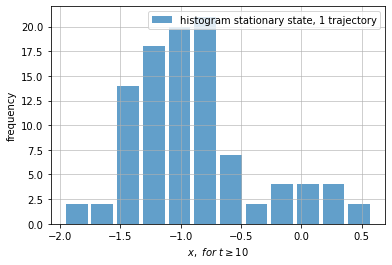

In [18]:
n, bins, patches = plt.hist(x=X[100:,0], 
                            bins='auto', alpha=0.7, rwidth=0.85, label = 'histogram stationary state, 1 trajectory')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$x, \ for \ t \geq 10$')
plt.ylabel(r'frequency')
plt.legend()
plt.show()

#### 4. Construct a histogram with the values taken for the system over all trajectories at the stationary state

In [19]:
X_st_flat = X[100:, :].flatten()

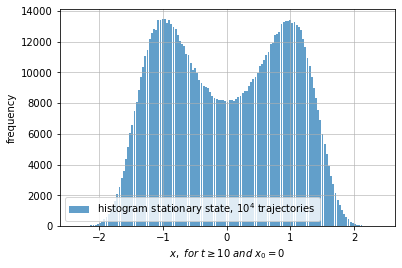

In [48]:
n, bins, patches = plt.hist(x=X_st_flat, bins='auto',
                            alpha=0.7, rwidth=0.85, label = r'histogram stationary state, $10^4$ trajectories')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$x, \ for \ t \geq 10 \ and \ x_0 = 0$')
plt.ylabel(r'frequency')
plt.legend(loc = 'lower left')
plt.show()

#### 5. Exploring the decay to the stable states for different initial conditions

In [21]:
T, X_ = Trajectories_Euler_Maruyama(x_0 = np.random.uniform(-5, 5, n_sim))

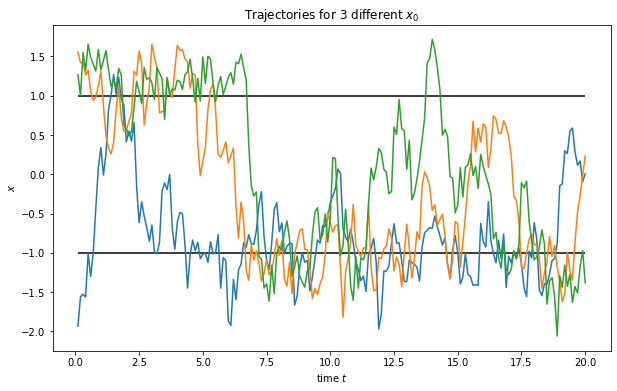

In [22]:
plt.figure(figsize=(10,6))
plt.plot(T, X_[:, :3]);
plt.hlines(a, T[0], T[-1], color = 'k')
plt.hlines(-a, T[0], T[-1], color = 'k')
plt.title(label = 'Trajectories for 3 different $x_0$')
plt.xlabel(r'time $t$')
plt.ylabel(r'$x$')
# plt.legend()
plt.show()

#### 6. Theoretical solution

Solving for the Fokker-Planck probability density function at the stationary situation, $f^{st}(t)$, from \eqref{SDE_}, for: $$ q(x) = -\frac{d}{dx}V(x) = x - x^3 \\
    \Leftrightarrow V(x) = -\frac{x^2}{2} + \frac{x^4}{4}.
$$
Then: $$ f^{st}(x) = e^{-2V(x)/\sqrt{D}}/N
$$
taken from Berglund paper; where $\int_{-\infty}^{+\infty}f^{st}(x)dx = 1$ and $N$ is the normalization constant.

In [23]:
x = np.linspace(-3, 3)
y = np.exp(2*(x**2/2 - x**4/4))/4.166 # N = 4.166, a = 1

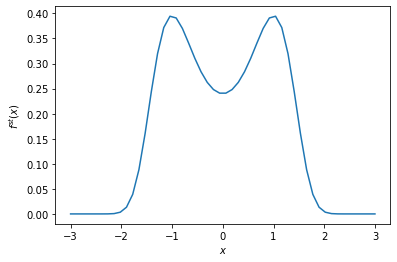

In [24]:
plt.plot(x, y);
plt.xlabel(r'$x$')
plt.ylabel(r'$f^{st}(x)$')
plt.show()

##### Compare analytical with numerical stationary solution of the probablity density function that gives the probability to find the system at a given location $x$ in phase space at a time $t \gg 0$

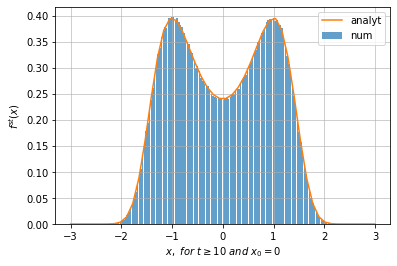

In [25]:
n, bins, patches = plt.hist(x=X_st_flat, bins='auto', density = True, # density=True normalizes the histogram
                            alpha=0.7, rwidth=0.85, label = r'num')
plt.plot(x, y, label = 'analyt');
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$x, \ for \ t \geq 10 \ and \ x_0 = 0$')
plt.ylabel(r'$f^{st}(x)$')
plt.legend()
plt.show()

for a = 4:

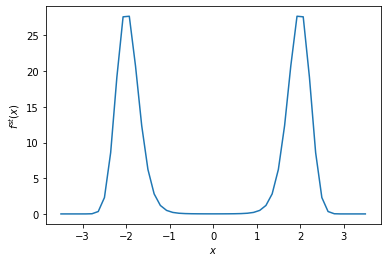

In [26]:
x = np.linspace(-3.5, 3.5)
y = np.exp(2*(4*x**2/2 - x**4/4))/103.5 
plt.plot(x, y);
plt.xlabel(r'$x$')
plt.ylabel(r'$f^{st}(x)$')
plt.show()

### First Passage Time Problem.....under construction

In [35]:
# Heun_first_passage_time program, page 224
# initial conditions
x_0 = 0 
t_0 = 0
# parameter values
a = 4
D = 0.1

x_b = 1.0 # boundary of region A (after A, the trajectory is defined in a deterministic way)
h = 0.01   # time step of numerical calculation
t_max = 100.0 # program finishes after maximum time t_max

n_tra = int(1e4) # number of trajectories

In [36]:
X_A = [[] for i in range(n_tra)]
T_esc = [[] for i in range(n_tra)]

In [37]:
for i_tra in range(n_tra): # vectorize it?
    x = x_0
    t = t_0
    while np.abs(x) < x_b:
        uh = np.sqrt(h) * np.random.normal(loc = 0.0, scale = 1.0) #ui, indepednent Gaussian RV
        aux = h * q(t,x) + uh * g(t,x)
        x = x + 0.5 * (aux + h * q(t + h, x + aux) + uh * g(t + h, x + aux))
        t = t + h
        if t > t_max:
            print('WARNING. Maximum integration time reached.')
            print('Trajectory, {}, has not crossed the boundary', format(i_tra))
        X_A[i_tra].append(x) 
        T_esc[i_tra].append(t) 


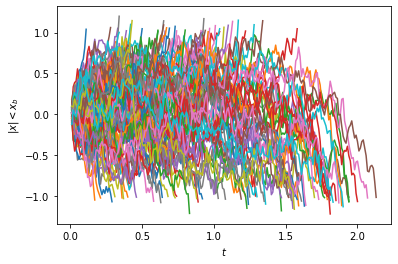

In [43]:
for i in range(100):
    plt.plot(T_esc[i], X_A[i])
plt.xlabel(r'$t$')
plt.ylabel(r'$|x|<x_b$')
# plt.legend()
plt.show()

In [39]:
Tpoints_esc = np.array([sublist[-1] for sublist in T_esc])

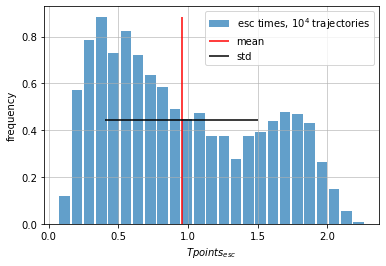

In [46]:
n, bins, patches = plt.hist(x=Tpoints_esc, bins='auto', density = True,
                            alpha=0.7, rwidth=0.85, label = r'esc times, $10^4$ trajectories')
plt.vlines(Tpoints_esc.mean(), 0, n.max(), color = 'r', label = 'mean')
plt.hlines(n.max()/2, Tpoints_esc.mean() - np.std(Tpoints_esc), Tpoints_esc.mean() + np.std(Tpoints_esc), color = 'k', label = 'std')
plt.grid(axis='both', alpha=0.75)
plt.xlabel(r'$Tpoints_{esc}$')
plt.ylabel(r'frequency')
plt.legend()
plt.show()

##### theoretical confirmation? Calculate analytically pdf $P(T)$